In [31]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_validate, train_test_split

Foi construida uma função para download dos dados da origem do [UCI](https://archive.ics.uci.edu/static/public/101/tic+tac+toe+endgame.zip). O dado é baixado, extraído do ZIP e separado entre características e classe.

In [8]:
from download_data import download_data

A biblioteca construída para o `AdaBoost` utiliza a classe `DecisionStump` (também construída) como *weak learner*.

#### `DecisionStump`

O algorítmo `DecisionStump` implementa uma árvore de decisão que contém somente um nó e duas folhas de classificação. O nó de decisão é calculado da forma clássica utilizando ganho de informação dado pela redução de entropia causada por cada possível decisão.

A fórmula de cálculo de entropia (`H`) de uma árvore de decisão é:

$$
H(p, n) = -\frac{p}{p + n} \times log \Bigg( \frac{p}{p + n} \Bigg)
$$

Em que $p$ é o número de observações da classe positiva e $n$ é o número de observações da classe negativa. Isso é o equivalente á somar 1 para cada obervação existente em cada classe, ou seja, cada obervação de cada classe tem peso igual e igual a 1.

Para possibilitar a aplicação de pesos para cada observação dos dados (como necessário para a aplicação do AdaBoost) foi seguida a seguinte fórmula:

$$
p = \sum{w_{p_i}} \;;\;\; n = \sum{w_{n_i}}
$$

No caso de pesos iguais a 1 a soma $\sum{w_{p_i}}$ é exatamente igual a quantidade de observações, e quando o peso de cada observação é diferente a entropia calculada em função dessas observações será mais valorizada ou menos valorizada.

#### `AdaBoost`

O algoritmo do `AdaBoost` atualiza pesos de cada observação em função do erro de predição ($E$) avaliado no modelo da iteração ($m$) atual.

$$
E_m = \frac{1}{N} \sum^N_{i=1} I(y_i \neq G(x_i))
$$

Em que:

- $N$ é o número de observações
- $y_i$ é o valor real associado à classe da observação $i$
- $G(x_i)$ é a predição do modelo $G$ para as características $x$ da observação $i$
- $I$ é a função indicadora da diferença entre o previsto e o real

O valor ($\alpha_m$) para atualização dos pesos na iteração $m$ é atualizado da seguinte forma:

$$
\alpha_m = log \Bigg( \frac{1 - E_m}{E_m} \Bigg)
$$

O novo peso $w$ da observação $i$ é:

$$
w_{i} \leftarrow w_i \cdot exp(\alpha_m \cdot I(y_i \neq G_m(x_i)))
$$

Para calcular a predição total de todas as iterações geradas pelo `AdaBoost`:

$$
G(x) = sign \Bigg( \sum^M_{m=1} \alpha_m G_m(x) \Bigg)
$$

In [ ]:
from adaboost import AdaBoost

In [3]:
data, target = download_data()
data.shape, target.shape

((958, 9), (958,))

Para analisar o modelo construido ele será treinado com diferentes valores de número de iterações. A expectativa é que o *weak learner* `DecisionStump` a cada iteração do `AdaBoost` gere resultados melhores para prever as classes do dado disponível.

In [4]:
results = list()

for iterations in tqdm([1, 2, 3, 4, 7, 10, 20, 30, 50, 80, 150, 300]):
    model = cross_validate(
        estimator=AdaBoost(iterations=iterations),
        X=data, y=target,
        cv=5, n_jobs=5, scoring='accuracy'
    )

    results.append({
        'iterations': iterations,
        'fit_time': np.mean(model['fit_time']),
        'accuracy': np.mean(model['test_score']),
    })

100%|██████████| 12/12 [00:14<00:00,  1.18s/it]


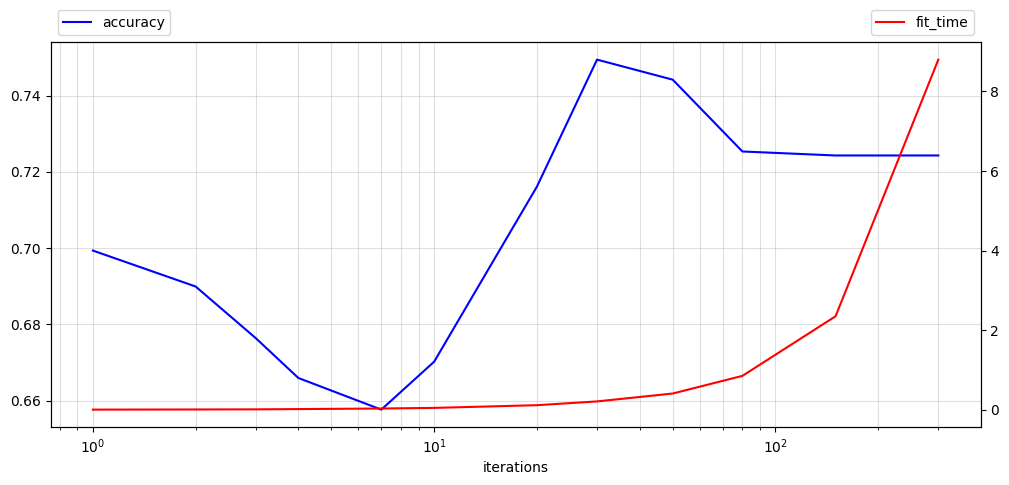

In [5]:
df = pd.DataFrame(results)
plt.figure(figsize=(12, 5))

ax = plt.gca()
df.plot(x='iterations', y='accuracy', color='blue', ax=ax)
axt = ax.twinx()
df.plot(x='iterations', y='fit_time', color='red', ax=axt)

ax.set_xscale('log')
ax.grid(True, axis='both', which='both', alpha=.4)

ax.legend(loc='lower left', bbox_to_anchor=(0, 1))
axt.legend(loc='lower right', bbox_to_anchor=(1, 1))

plt.show()
plt.close()

Nota-se que a acurácia média dos 5 *folds* da validação cruzada alcançada por cada modelo do `AdaBoost` com diferentes números de iterações se altera significativamente quanto maior o número de iterações. Vale ressaltar que quanto maior o número de iterações certamente maior o tempo necessário para o treinamento do modelo.

O modelo que apresenta a melhor performance na métrica de acurácia é o modelo com 30 iterações. Outra forma de avaliar a performance do modelo é de avaliar a performance do modelo a cada iteração adicionada no algoritmo de *boosting*. Nesse caso a métrica é calculada para o conjunto de dados de treinamento.

Pra isso foi adicionado a variável `iter_acc_` na classe do modelo `AdaBoost` que pode ser avaliado em seguida.

In [9]:
accuracies = AdaBoost(iterations=300).fit(data, target).iter_acc_

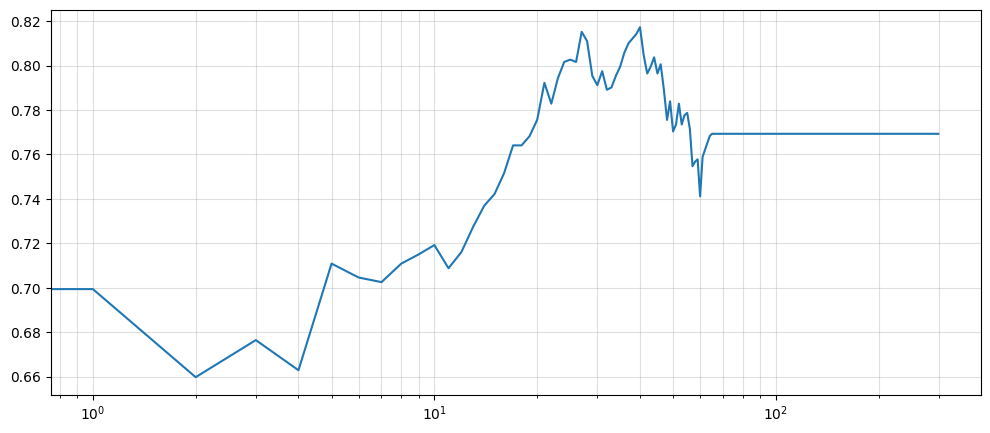

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(accuracies)
plt.xscale('log')
plt.grid(True, axis='both', which='both', alpha=.4)
plt.show()
plt.close()

De forma similar à avaliação utilizando validação cruzada, o teste a cada iteração do modelo apresenta que o melhor modelo está entre 20 e 30 iterações.

Para estimar o comportamento médio do modelo para 27 iterações o experimento será repetindo 100 vezes.

In [43]:
results = list()
for _ in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
    model = AdaBoost(iterations=27).fit(X_train, y_train)
    results.append(accuracy_score(y_true=y_test, y_pred=model.predict(X_test)))

100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


In [47]:
{
    'max': np.max(results),
    'mean': np.mean(results),
    'min': np.min(results),
}

{'max': 0.8489583333333334,
 'min': 0.7135416666666666,
 'mean': 0.7728645833333333}

---